In [1]:
import torch
from data_utils import GuidedGridMLMDataset, GuidedGridMLM_collate_fn
from torch.utils.data import DataLoader
from GridMLM_tokenizers import GuidedGridMLMTokenizer
from models import GuidedMLMH
from tqdm import tqdm
import numpy as np

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device_name = 'cuda:2'
val_dir = '/media/maindisk/data/hooktheory_hr/hooktheory_CA_test'
jazz_dir = '/media/maindisk/data/gjt_melodies/gjt_CA'
subfolder = 'CA'
curriculum_type='random'
ablation = 'all'

In [3]:
model_path = 'saved_models/' + subfolder + '/' + curriculum_type + '_' + ablation + '.pt'
tokenizer = GuidedGridMLMTokenizer(fixed_length=256)
val_dataset = GuidedGridMLMDataset(val_dir, tokenizer, 512, frontloading=True)
jazz_dataset = GuidedGridMLMDataset(jazz_dir, tokenizer, 512, frontloading=True)

Loading data file.
Frontloading data.


  0%|          | 0/547 [00:00<?, ?it/s]/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
  4%|▍         | 23/547 [00:03<01:23,  6.25it/s]/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/musicxml/xmlToM21.py:4848: MusicXMLWarning: Cannot put in an element with a missing voice tag when no previous voice tag was given.  Assuming voice 1... 
  warnings.warn('Cannot put in an element with a missing voice tag when '
100%|██████████| 547/547 [01:24<00:00,  6.48it/s]


In [4]:
if device_name == 'cpu':
        device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device(device_name)
    else:
        print('Selected device not available: ' + device_name)
vae_cfg = {
    'input_dim': 512,
    'hidden_dim': 256,
    'latent_dim': 128,
    'embedding_dim': 64,
    'seq_len': 256,
    'feature_dim': 37,
}
encoder_cfg = {
    'nhead': 8,
    'num_layers': 8,
    'stage_embedding_dim': 64,
    'max_stages': 10
}
model = GuidedMLMH(
    vae_cfg=vae_cfg,
    encoder_cfg=encoder_cfg,
    chord_vocab_size=len(tokenizer.vocab),
    d_model=512,
    conditioning_dim=16,
    pianoroll_dim=100,
    grid_length=256,
    guidance_dim=128,
    unfold_latent=True,
    device=device,
)
checkpoint = torch.load(model_path, map_location=device_name)
model.load_state_dict(checkpoint)
model.eval()
model.to(device)

GuidedMLMH(
  (condition_proj): Linear(in_features=16, out_features=512, bias=True)
  (melody_proj): Linear(in_features=100, out_features=512, bias=True)
  (harmony_embedding): Embedding(354, 512)
  (guidance_to_dmodel): Linear(in_features=128, out_features=512, bias=True)
  (vae): GuidanceVAE(
    (embedding): Embedding(354, 64)
    (encoder_rnn): LSTM(64, 256, batch_first=True)
    (mu_proj): Linear(in_features=256, out_features=128, bias=True)
    (logvar_proj): Linear(in_features=256, out_features=128, bias=True)
    (decoder_rnn): LSTM(128, 256, batch_first=True)
    (recon_proj): Linear(in_features=256, out_features=354, bias=True)
    (feature_proj): Linear(in_features=128, out_features=37, bias=True)
  )
  (encoder): GridMLMMelHarmEncoder(
    (stage_embedding): Embedding(10, 64)
    (stage_proj): Linear(in_features=576, out_features=512, bias=True)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): 

In [5]:
zs = []
z_idxs = []
for d in tqdm(val_dataset):
    full_harmony = torch.tensor(d['input_ids']).reshape(1, len(d['input_ids']))
    z = model.get_z_from_harmony(full_harmony.to(device)).detach().cpu()[0].tolist()
    zs.append(z)
    z_idxs.append(0)
for d in tqdm(jazz_dataset):
    full_harmony = torch.tensor(d['input_ids']).reshape(1, len(d['input_ids']))
    z = model.get_z_from_harmony(full_harmony.to(device)).detach().cpu()[0].tolist()
    zs.append(z)
    z_idxs.append(0)

100%|██████████| 547/547 [00:02<00:00, 260.59it/s]


In [6]:
z_np = np.array( zs )

In [7]:
print(z_np.shape)

(1333, 128)


In [8]:
from sklearn.manifold import TSNE

In [9]:
z_tnse = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=2).fit_transform(z_np)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 1333 samples in 0.001s...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

[t-SNE] Computed neighbors for 1333 samples in 0.407s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1333
[t-SNE] Computed conditional probabilities for sample 1333 / 1333
[t-SNE] Mean sigma: 1.629910
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 97.2003708, gradient norm = 0.0327270 (50 iterations in 0.125s)
[t-SNE] Iteration 100: error = 99.4475937, gradient norm = 0.0343855 (50 iterations in 0.109s)
[t-SNE] Iteration 150: error = 96.8439484, gradient norm = 0.1912798 (50 iterations in 0.095s)
[t-SNE] Iteration 200: error = 96.5369034, gradient norm = 0.2432046 (50 iterations in 0.076s)
[t-SNE] Iteration 250: error = 95.9991913, gradient norm = 0.3434677 (50 iterations in 0.073s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.999191
[t-SNE] Iteration 300: error = 3.4065957, gradient norm = 0.0259521 (50 iterations in 0.068s)
[t-SNE] Iteration 350: error = 2.8959534, gradient norm = 0.0197208 (50 iterations 

In [10]:
print(z_tnse.shape)

(1333, 2)


In [11]:
import matplotlib.pyplot as plt

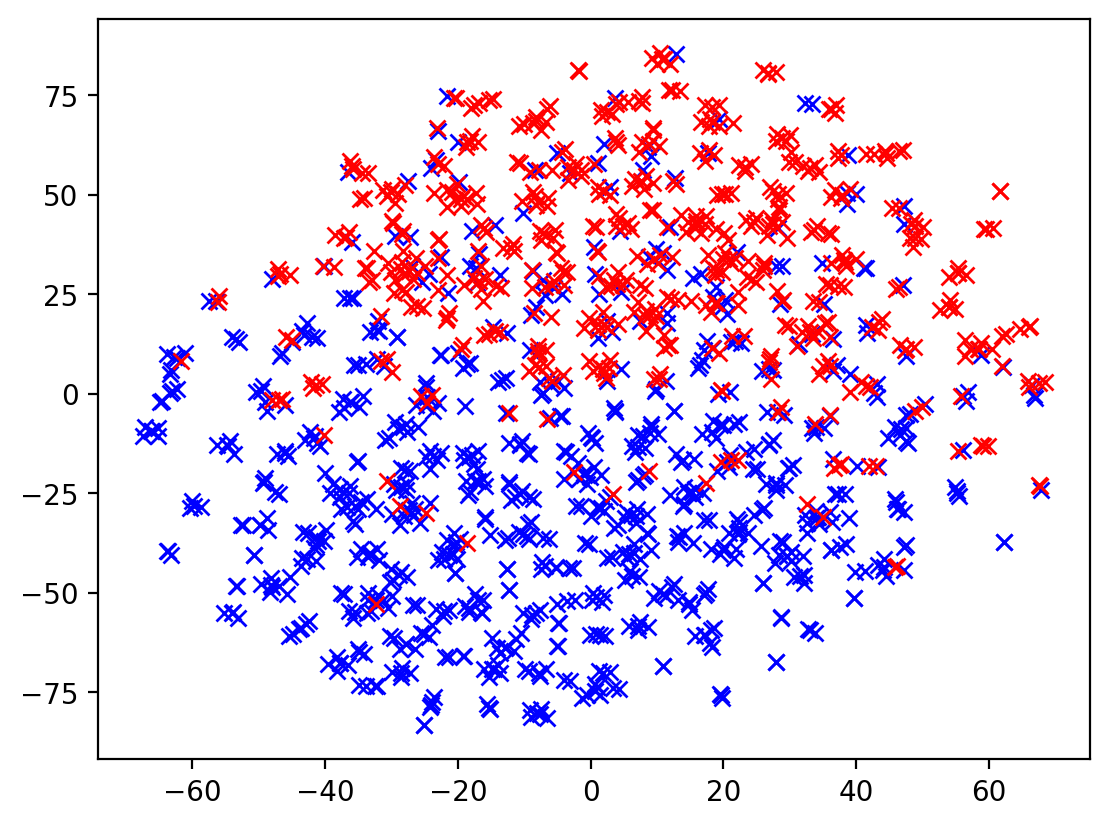

In [12]:
plt.plot(z_tnse[:len(val_dataset),0], z_tnse[:len(val_dataset),1], 'bx')
plt.plot(z_tnse[len(val_dataset):,0], z_tnse[len(val_dataset):,1], 'rx')